In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from math import sqrt, pi, exp
import seaborn as sns; sns.set_theme()
from canny import *

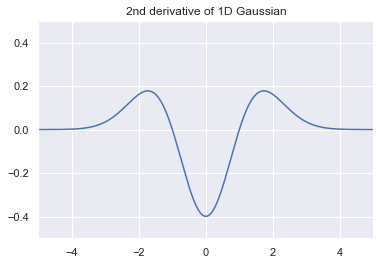

In [2]:
# Question 2a
x = np.arange(-5, 5, 0.01)
coeff = (np.square(x)-1)*(1/sqrt(2*pi))
y = (coeff)*np.exp((-1/2)*np.square(x))
plt.plot(x, y)
plt.axis([-5, 5, -0.5, 0.5])
plt.title("2nd derivative of 1D Gaussian")
plt.show()

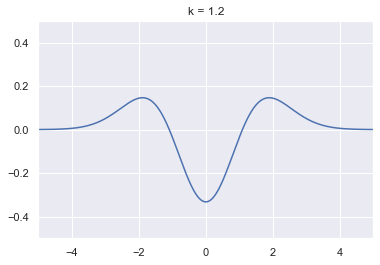

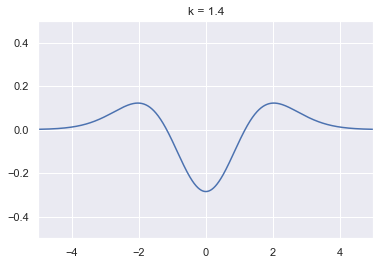

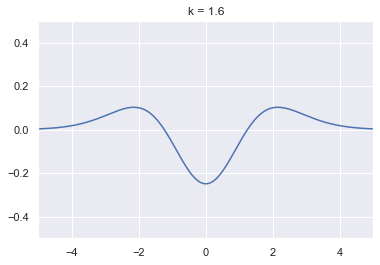

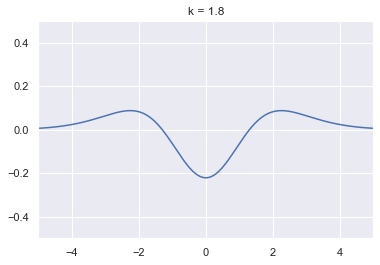

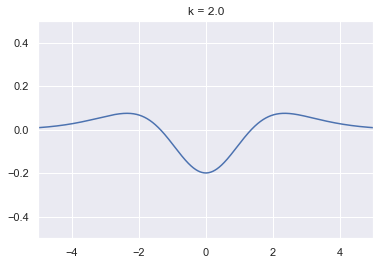

In [3]:
# Question 2b
def gaussian(k):
    return np.exp(np.square(x) / (-2*k*k)) / (sqrt(2*pi)*k)

for k in [1.2, 1.4, 1.6, 1.8, 2.0]:
    x = np.arange(-5, 5, 0.01)
    y = (gaussian(k) - gaussian(1)) / (k-1)
    plt.plot(x, y)
    plt.axis([-5, 5, -0.5, 0.5])
    plt.title("k = " + str(k))
    plt.show()

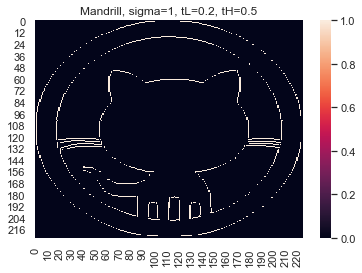

In [4]:
# test
img_mandrill = cv2.imread('githubim.png', 1)
gray_mandrill = cv2.cvtColor(img_mandrill, cv2.COLOR_BGR2GRAY)
gray_mandrill = np.array(gray_mandrill/255.0)
edgemap_mandrill = cannyEdgeDetection(gray_mandrill, 1, 0.2, 0.5)
ax = plt.axes()
ax = sns.heatmap(edgemap_mandrill)
ax.set_title('Mandrill, sigma=1, tL=0.2, tH=0.5')
plt.show()


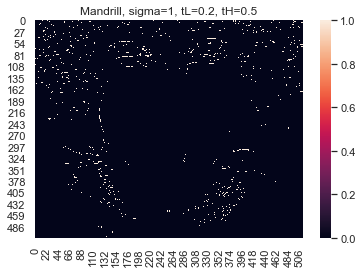

In [4]:
# Question 6a
img_mandrill = cv2.imread('example_images/mandrill.jpg', 1)
gray_mandrill = cv2.cvtColor(img_mandrill, cv2.COLOR_BGR2GRAY)
gray_mandrill = np.array(gray_mandrill/255.0)
edgemap_mandrill = cannyEdgeDetection(gray_mandrill, 1, 0.2, 0.5)
ax = plt.axes()
ax = sns.heatmap(edgemap_mandrill)
ax.set_title('Mandrill, sigma=1, tL=0.2, tH=0.5')
plt.show()


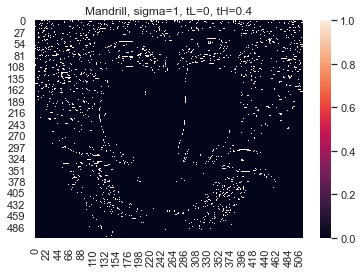

In [5]:
edgemap_mandrill = cannyEdgeDetection(gray_mandrill, 1, 0, 0.4)
ax = plt.axes()
ax = sns.heatmap(edgemap_mandrill)
ax.set_title('Mandrill, sigma=1, tL=0, tH=0.4')
plt.show()

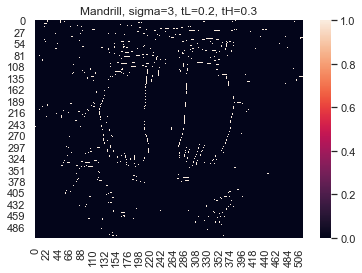

In [6]:
edgemap_mandrill = cannyEdgeDetection(gray_mandrill, 3, 0.2, 0.3)
ax = plt.axes()
ax = sns.heatmap(edgemap_mandrill)
ax.set_title('Mandrill, sigma=3, tL=0.2, tH=0.3')
plt.show()

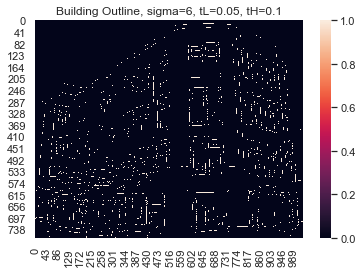

In [7]:
# Question 6b
img_cs = cv2.imread('example_images/csbldg.jpg', 1)
gray_cs = cv2.cvtColor(img_cs, cv2.COLOR_BGR2GRAY)
gray_cs = np.array(gray_cs/255.0)

# finding just the building outline
edgemap_cs = cannyEdgeDetection(gray_cs, 6, 0.05, 0.1)
ax = plt.axes()
ax = sns.heatmap(edgemap_cs)
ax.set_title('Building Outline, sigma=6, tL=0.05, tH=0.1')
plt.show()

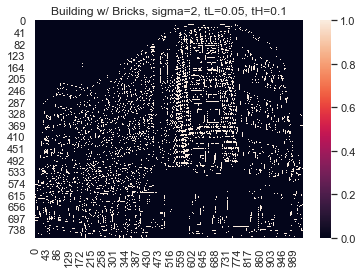

In [8]:
# finding edges between individual bricks
edgemap_cs = cannyEdgeDetection(gray_cs, 2, 0.05, 0.1)
ax = plt.axes()
ax = sns.heatmap(edgemap_cs)
ax.set_title('Building w/ Bricks, sigma=2, tL=0.05, tH=0.1')
plt.show()

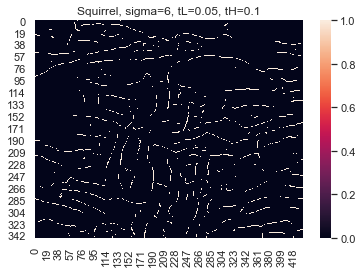

In [9]:
# Question 6c
img_cs = cv2.imread('test.jpeg', 1)
gray_sq = cv2.cvtColor(img_cs, cv2.COLOR_BGR2GRAY)
gray_sq = np.array(gray_sq/255.0)

# finding just the outline
edgemap_sq = cannyEdgeDetection(gray_sq, 6, 0.05, 0.1)
ax = plt.axes()
ax = sns.heatmap(edgemap_sq)
ax.set_title('Squirrel, sigma=6, tL=0.05, tH=0.1')
plt.show()

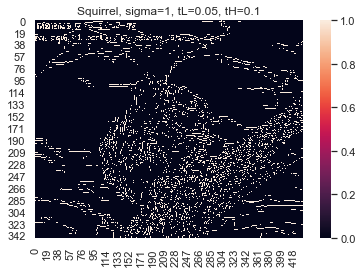

In [10]:
# more detail
edgemap_sq = cannyEdgeDetection(gray_sq, 1, 0.05, 0.1)
ax = plt.axes()
ax = sns.heatmap(edgemap_sq)
ax.set_title('Squirrel, sigma=1, tL=0.05, tH=0.1')
plt.show()

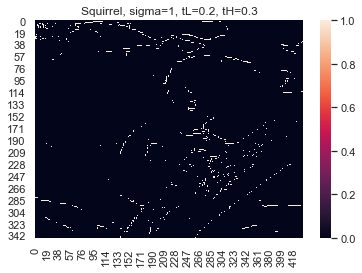

In [11]:
# high detail, higher threshold
edgemap_sq = cannyEdgeDetection(gray_sq, 1, 0.2, 0.3)
ax = plt.axes()
ax = sns.heatmap(edgemap_sq)
ax.set_title('Squirrel, sigma=1, tL=0.2, tH=0.3')
plt.show()

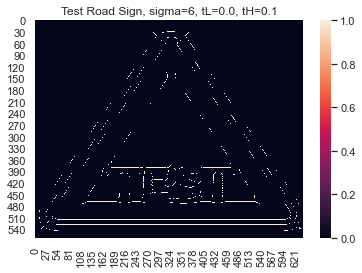

In [12]:
# Question 6c - another image
img_rs = cv2.imread('road_sign.png', 1)
gray_rs = cv2.cvtColor(img_rs, cv2.COLOR_BGR2GRAY)
gray_rs = np.array(gray_rs/255.0)

# finding just the outline
edgemap_rs = cannyEdgeDetection(gray_rs, 6, 0.0, 0.1)
ax = plt.axes()
ax = sns.heatmap(edgemap_rs)
ax.set_title('Test Road Sign, sigma=6, tL=0.0, tH=0.1')
plt.show()

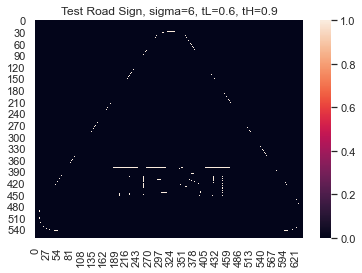

In [13]:
# increasing thresholds
edgemap_rs = cannyEdgeDetection(gray_rs, 6, 0.6, 0.9)
ax = plt.axes()
ax = sns.heatmap(edgemap_rs)
ax.set_title('Test Road Sign, sigma=6, tL=0.6, tH=0.9')
plt.show()

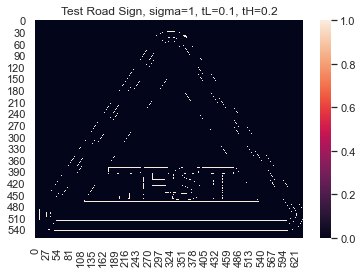

In [14]:
# trying to find "detail" in a fairly undetailed image
edgemap_rs = cannyEdgeDetection(gray_rs, 1, 0.1, 0.2)
ax = plt.axes()
ax = sns.heatmap(edgemap_rs)
ax.set_title('Test Road Sign, sigma=1, tL=0.1, tH=0.2')
plt.show()

magnitude of gradient
D [[3.14159265 3.14159265 3.14159265 ... 3.14159265 3.14159265 3.14159265]
 [3.14159265 3.14159265 3.14159265 ... 3.14159265 3.14159265 3.14159265]
 [3.14159265 3.14159265 3.14159265 ... 3.14159265 3.14159265 3.14159265]
 ...
 [3.14159265 3.14159265 3.14159265 ... 3.14159265 3.14159265 3.14159265]
 [3.14159265 3.14159265 3.14159265 ... 3.14159265 3.14159265 3.14159265]
 [3.14159265 3.14159265 3.14159265 ... 3.14159265 3.14159265 3.14159265]]
F [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


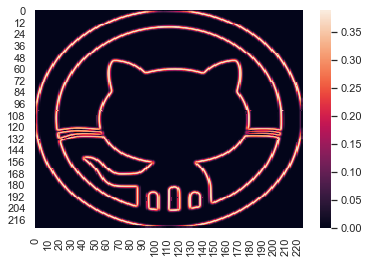

In [21]:
# Question 6d - all intermediate visuals made before finalizing canny.py
img = cv2.imread('githubim.png', 1)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2.imshow('image_gray', gray)
gray = np.array(gray/255.0)


def gauss(sigma): # get vertical 1d gaussian
    half_size = 3*sigma

    k = np.arange(-half_size, half_size+1, 1)

    return np.exp(np.square(k) / (-2*sigma**2)) / (sqrt(2*pi)*sigma)


def deriv_gauss(sigma): # get vertical 1d gaussian derivative
    half_size = 3*sigma

    k = np.arange(-half_size, half_size+1, 1)

    return np.exp(np.square(k) / (-2*sigma**2)) * (-k / (sqrt(2*pi)*sigma**3))


GpTy = np.expand_dims(deriv_gauss(1), axis=1)     # vertical derivative of a Gaussian for y
Gx = np.expand_dims(gauss(1), axis=0)            # horizontal gaussian for x
GTy = np.expand_dims(gauss(1), axis=1)             # vertical Gaussian y
Gpx = np.expand_dims(deriv_gauss(1), axis=0)   # horizontal derivative of Gaussian for x

Fx = cv2.filter2D((cv2.filter2D(gray, -1, GTy)), -1, Gpx)
Fy = cv2.filter2D((cv2.filter2D(gray, -1, Gx)), -1, GpTy)

# Computer edge strength and edge orientation at each pixel.
def edge_str_ori(fx, fy, img):
    F = np.sqrt(np.square(fx) + np.square(fy))
    div = fy / (fx+1e-13)
    D = np.arctan(div)
    D = np.where(D > 0, D, D+pi)
    return F, D

F, D = edge_str_ori(Fx, Fy, gray)
print("magnitude of gradient")
ax1 = sns.heatmap(F)
print("D", D)
print("F", F)

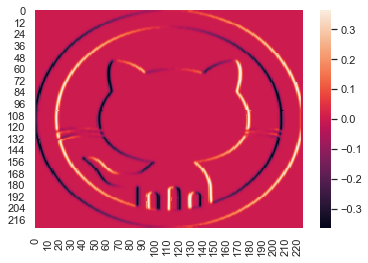

In [22]:
ax01 = sns.heatmap(Fx)

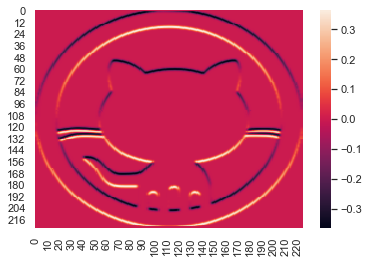

In [23]:
ax02 = sns.heatmap(Fy)

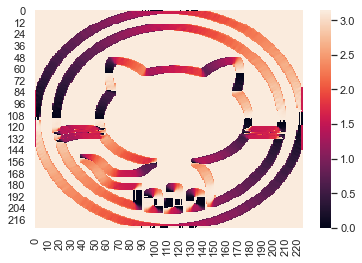

In [24]:
ax2 = sns.heatmap(D)

[[2.35619449 2.35619449 2.35619449 ... 2.35619449 2.35619449 2.35619449]
 [2.35619449 2.35619449 2.35619449 ... 2.35619449 2.35619449 2.35619449]
 [2.35619449 2.35619449 2.35619449 ... 2.35619449 2.35619449 2.35619449]
 ...
 [2.35619449 2.35619449 2.35619449 ... 2.35619449 2.35619449 2.35619449]
 [2.35619449 2.35619449 2.35619449 ... 2.35619449 2.35619449 2.35619449]
 [2.35619449 2.35619449 2.35619449 ... 2.35619449 2.35619449 2.35619449]]
direction of gradient (4 options)


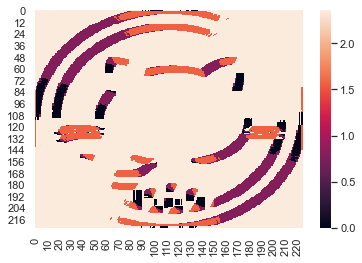

In [25]:
# For each pixel, find the direction 𝐷∗∈0,𝜋/4,𝜋/2,3𝜋/4 that is closest to the orientation 𝐷 at that pixel.
angles = np.array([0, pi/4, pi/2, 3*pi/4])
D_prime = np.zeros(D.shape)
for i in range(D.shape[0]):
    for j in range(D.shape[1]):
        D_prime[i][j] = angles[np.abs(angles - D[i][j]).argmin()]
print(D_prime)
print("direction of gradient (4 options)")
ax3 = sns.heatmap(D_prime)

after NMS


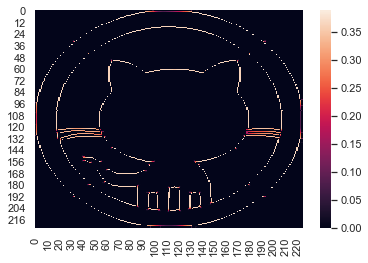

In [26]:
# If the edge strength 𝐹(𝑥,𝑦) is smaller than at least one of its neighbors along 𝐷∗, 
# set 𝐼(𝑥,𝑦)=0, else set 𝐼(𝑥,𝑦)=𝐹(𝑥,𝑦).

I = np.zeros(gray.shape)
for i in range(I.shape[0]):
    for j in range(I.shape[1]):
        if D_prime[i][j] == 0:
            n1, n2 = (i, max(0,j-1)), (i, min(I.shape[1]-1,j+1))
        elif D_prime[i][j] == pi/4:
            n1, n2 = (max(0,i-1), min(I.shape[1]-1,j+1)), (min(I.shape[0]-1, i+1), max(0,j-1))
        elif D_prime[i][j] == pi/2:
            n1, n2 = (max(0,i-1), j), (min(I.shape[0]-1, i+1), j)
        else:
            n1, n2 = (max(0,i-1), max(0,j-1)), (min(I.shape[0]-1, i+1), min(I.shape[1]-1,j+1))
            
        if F[i][j] >= F[n1] and F[i][j] >= F[n2]:
            I[i][j] = F[i][j]
            
print("after NMS")
ax4 = sns.heatmap(I)

normalized I


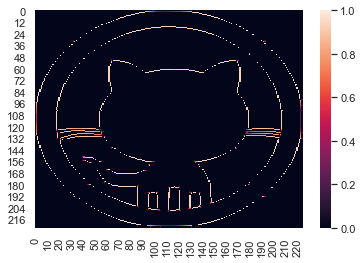

In [27]:
edgemap = np.zeros(I.shape)
I_normal = I / np.amax(I)
print("normalized I")
ax44 = sns.heatmap(I_normal)

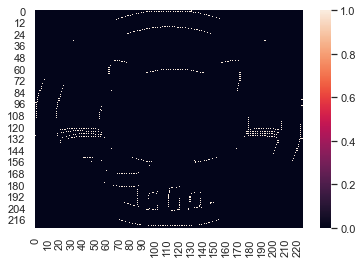

In [28]:

th = 0.2
tl = 0.1
for i in range(I.shape[0]):
    for j in range(I.shape[1]):
        if I_normal[i][j] > th:
#             edgemap[i][j] = 1
            to_check = [(i,j)]
            while(to_check):
                p = to_check.pop(0)
                if edgemap[p] == 0:
                    if D_prime[i][j] == 0:
                        n1, n2 = (max(0,p[0]-1), p[1]), (min(I.shape[0]-1, p[0]+1), p[1])
                    elif D_prime[i][j] == pi/4:
                        n1, n2 = (max(0,p[0]-1), max(0,p[1]-1)), (min(I.shape[0]-1, p[0]+1), min(I.shape[1]-1,p[1]+1))
                    elif D_prime[i][j] == pi/2:
                        n1, n2 = (p[0], max(0,p[1]-1)), (p[0], min(I.shape[1]-1,p[1]+1))
                    else:
                        n1, n2 = (max(0,p[0]-1), min(I.shape[1]-1,p[1]+1)), (min(I.shape[0]-1, p[0]+1), max(0,p[1]-1))
                    if I_normal[n1] > tl:
                        to_check.append(n1)
                        edgemap[n1] = 1
                    if I_normal[n2] > tl:
                        to_check.append(n2)
                        edgemap[n2] = 1
                    
ax5 = sns.heatmap(edgemap)